In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
TWOPI = 2 * np.pi

In [136]:
# create a 2D dataset to make things simpler

def polar_to_cartesian(vec):
    r = vec[:, 0]
    theta = vec[:, 1]
    return np.array([r * np.cos(theta), r * np.sin(theta)]).T

def window(r):
    radius = np.sqrt(r[:, 0]**2 + r[:, 1]**2)
    return r[radius <= 1]

N_cluster = 100
N_c = 10 # points per cluster
clusters = np.array([np.random.uniform(size=N_cluster), np.random.uniform(size=N_cluster) * TWOPI]).T
clusters = polar_to_cartesian(clusters)

data = np.zeros((N_cluster * N_c, 2))
var = 0.001
for c in range(N_cluster):
    data[c * N_c: (c + 1) * N_c] = np.random.multivariate_normal(mean=clusters[c], cov=var * np.eye(2), size=N_c)

uniform_data = np.random.uniform(-1, 1, size=(N_cluster * N_c, 2)) # homogeneous poisson point process
    
# apply the window function
data = window(data)
data_u = window(uniform_data)

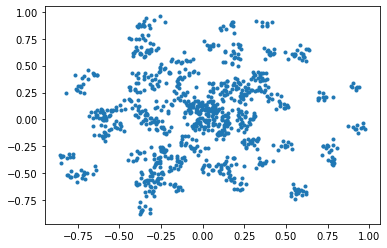

In [137]:
plt.scatter(data[:, 0], data[:, 1], marker=".")

## Pseudo pixelization (Tegmark 1995)

We apply a pixelization scheme $\mathbf{r}_i$ that will reduce the sidelob effect in k-space

That is, we work with the overdensity estimators
$$
    z_i = \int_V \varphi_i(\mathbf{r}) [n(\mathbf{r}) - \bar{n}(\mathbf{r})] d^2r
$$
where $\varphi_i$ are symmetric basis function, usually selected to be gaussian, $n(\mathbf{r})$ is the counting function of the sample and $\bar{\mathbf{n}}$ is the same function but counting over 
$$
    \varphi_i = \propto \exp \left[ -\frac{1}{2} \frac{||\mathbf{r} -\mathbf{r}_i||^2}{\sigma^2_i}\right]
$$
where the $\sigma_i$ are selected to be slightly greater than the neighboring points $r_i$. Also, one should choose points more sparsly in the outskirt of the survey.

Here, the selection function $n(\mathbf{r})$ is defined as

(-0.9842105263157894,
 0.9842105263157894,
 -0.9842105263157894,
 0.9842105263157894)

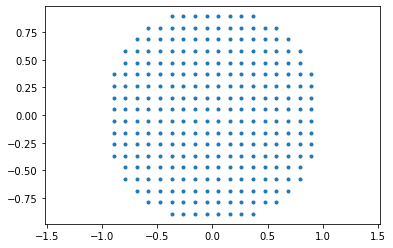

In [138]:
# pixelization -> compute position of the center of each pixel
N_i = 20
ell = 2 / N_i # side length of a pixel
x = np.linspace(-1, 1, N_i)
grid_x, grid_y = np.meshgrid(x, x)
grid = np.column_stack([grid_x.flatten(), grid_y.flatten()]) # get a coordinate array
grid = window(grid) 
plt.scatter(grid[:, 0], grid[:, 1], marker=".")
plt.axis("equal")

In [139]:
# pixel count -> count the number of marks in a pixel
# for a square pixel, this means the position of a given mark fall inside
def square_pixel_count(r, r_i, ell):
    # r: position of the marks
    # r_i: position of the center of each pixel
    right_condition =  r[np.newaxis, :, 0] < r_i[:, np.newaxis, 0] + ell/2
    left_condition = r[np.newaxis, :, 0] > r_i[:, np.newaxis, 0] - ell/2
    up_condition = r[np.newaxis, :, 1] < r_i[:, np.newaxis, 1] + ell/2
    down_condition = r[np.newaxis, :, 1] > r_i[:, np.newaxis, 1] - ell/2
    return (right_condition * left_condition * up_condition * down_condition).sum(axis=1)

In [140]:
count = square_pixel_count(data, grid, ell)
count_u = square_pixel_count(data_u, grid, ell)

## Cell count analysis (Efstathiou 1990 and 1995, MNRAS)

We want to compute the variance excess above Poisson noise

$$
    \bar{N} = \frac{1}{N_p}\sum_{i }N_i
$$
where $N_p$ is the number of pixels. To compute the excess variance, we computer the variance of the data minus the variance of a poisson statistic (equals the mean)
$$
    S = \frac{1}{N_p - 1} \sum_{i}(N_i - \bar{N})^2 - \bar{N}
$$

In [141]:
N_bar = count.mean()
excess_variance = count.var(ddof=1) - N_bar
excess_variance

17.46490118577075

In [142]:
N_bar_u = count_u.mean()
excess_variance_u = count_u.var(ddof=1) - N_bar_u
excess_variance_u

-0.028010540184453703

2.4746376811594204

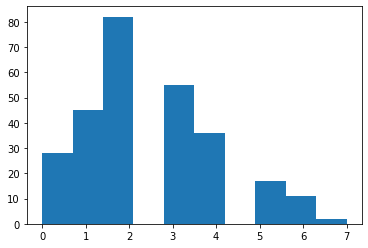

In [143]:
plt.hist(count_u)
N_bar_u

# Power spectra

Test some power spectra method

In [151]:
image, bin_x, bin_y = np.histogram2d(data[:, 0], data[:, 1], bins=100)
image_u, bin_x, bin_y = np.histogram2d(data_u[:, 0], data_u[:, 1], bins=100)

In [220]:
# first, test power_spectra from fft2
def power_spectra_from_image(image):
    n = image.shape[0]
    i_hat = np.fft.fft2(image)
    f = np.fft.fftfreq(n) * n # pixel frequency
    freq_x, freq_y = np.meshgrid(f, f)
    fnorm = np.sqrt(freq_x**2 + freq_y**2).flatten()
    f_amp = np.abs(i_hat).flatten()**2

    # we compute the average power spectra in each bin
    kbins = np.arange(0.5, n//2 + 0.5, 1.) # edge of kbins
    kvals = 0.5 * (kbins[1:] + kbins[:-1]) # actual value of the kbin
    Abins, _, _ = binned_statistic(fnorm, f_amp,
                                         statistic = "mean",
                                         bins = kbins)
    # Abins is only the average power spectra, we need to multiply by the volume in kspace
    Abins *= 4 * np.pi / 3 * (kbins[1:]**3 - kbins[:-1]**3)
    return kvals, Abins

Text(0, 0.5, 'P')

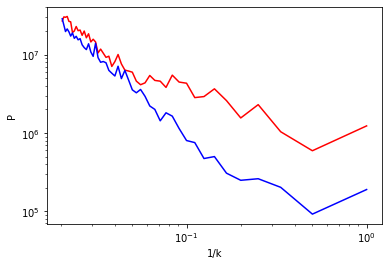

In [227]:
k, P = power_spectra_from_image(image)
k_u, P_u = power_spectra_from_image(image_u)
plt.plot(1/k, P, "-r")
plt.plot(1/k_u, P_u, "-b")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("1/k")
plt.ylabel("P")

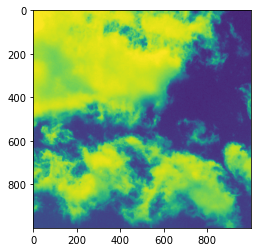

In [223]:
import matplotlib.image as mpimg

image_c = mpimg.imread("clouds.png")
plt.imshow(image_c)

In [224]:
k_c, P_c = power_spectra_from_image(image_c)

Text(0.5, 1.0, 'cloud')

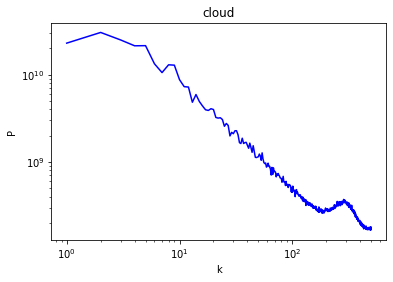

In [228]:
plt.plot(k_c, P_c, "-b")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("P")
plt.title("cloud")